In [ ]:
#default_exp FE

# Machine learning surrogate

> This module contains functions to train an Ml surragate of an HBM with data to train and test the model. This has functions to train, predict and get learning curves of  a surrogate.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import numpy as np
import yaml
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

class ML():

    def __init__(self, settings):
 
        self.settings = settings
        self._read_user_input()
     
    def _read_user_input(self): 
        with open(self.settings,'r') as file:
            inp = yaml.load(file, Loader=yaml.FullLoader) 
        inp_keys=[*inp.keys()]
        
        req=['data','ML method'] 
        
        for names in req:
            if names not in inp_keys:
                raise Exception(names +" not in input file")
            if inp[names] == None:
                raise Exception(names +" not in input file")

        self.datafile=inp['data']
        self.method=inp['ML method']
        self._read_data()

    def _read_data(self):
        self.X=pd.read_csv(self.datafile['input'])
        self.y=pd.read_csv(self.datafile['output'])
        self._ml_model()

    def _ml_model(self):
        if self.method['method']=='lasso':
            self.mod=Lasso()
        elif self.method['method']=='ridge':
            self.mod=Ridge()
        else:
            raise Exception("Enter a valid model")
        self._learning_curve()
        return self.mod
        

    def _learning_curve(self):
        self.cv = KFold(n_splits=10, random_state=1)
        self.train_size,self.train_score,self.test_score=learning_curve(self.mod,self.X,self.y,cv=self.cv,scoring='neg_mean_absolute_error')
        self.train_mean=-np.mean(self.train_score,axis=1)
        self.train_std=-np.std(self.train_score,axis=1)
        self.test_mean=-np.mean(self.test_score,axis=1)
        self.test_std=-np.std(self.test_score,axis=1)

    def plot_LC(self):
        plt.figure()
        plt.style.use('seaborn-ticks')
        plt.plot(self.train_size,self.train_mean, 'o-',label="Training score")
        plt.plot(self.train_size, self.test_mean, 'o-',label="Test score")
        plt.fill_between(self.train_size, self.train_mean - self.train_std, self.train_mean + self.train_std, alpha=0.2)
        plt.fill_between(self.train_size, self.test_mean - self.test_std, self.test_mean + self.test_std, alpha=0.2)
        plt.title("Learning Curve for {}".format(str(self.mod).split('(')[0]))
        plt.xlabel("Training Set Size")
        plt.ylabel("MAE")
        plt.legend(loc="best")
        plt.grid()
        plt.show()
    
    def predict(self,X_pre):
        X = self.X.to_numpy()
        y = self.y.to_numpy()
        kf=self.cv
        xp=pd.read_csv(X_pre)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            HBM_Train = self.mod.fit(X_train, y_train)
        self.prd=HBM_Train.predict(xp)
        return self.prd

# Using dynakit.ML to train models

## Process flow

![Work flow of ML](example/test_ML/process_flow.png)


The information required by dynakit to develop surrogates can by provided in two files located at the root of the **project directory**: *dynakit_ML.yaml*

### `dynakit_ML.yaml`

Use *dynakit_ML.yaml* to provide details to build the surrogate.

An example is given here:

```yaml

data:
  input: input.csv # file name with the X data 
  output: output.csv # file name with the y data

ML method:
  method: ridge # define the method
  parameters: # define hyperparameters
        alpha : 0.000001
        selection: random

``` 

In [ ]:
#hide
import os
os.chdir('example/test_ML')

In [ ]:
# hide
# define object using the dynakit_ML.yaml file
k=ML('dynakit_ML.yaml')

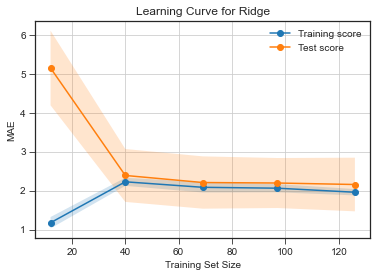

In [ ]:
#hide
# use .plot_LC to check the learning curve
k.plot_LC()

In [ ]:
#hide
# use .predict to use the trained model to predict for new X
k.predict("tst.csv")

array([[-45.05577922],
       [-42.20864056],
       [-37.92892393],
       [-27.87185926]])